In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from TCN.TCN.tcn import TCN_DimensionalityReduced

C:\Users\chris\AppData\Local\Temp\ipykernel_39512\2683153723.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
sns.set("notebook", "whitegrid")

# Data

In [3]:
class ECGDataset(Dataset):
    def __init__(self, data_dir, item_transform=None, target_transform=None, in_memory=True) -> None:
        self.data_dir = data_dir
        self.lengths = {}
        self.item_transform = item_transform
        self.target_transform = target_transform
        self.data = []
        self.in_memory = in_memory
        for _, _, files in os.walk(data_dir):
            for file in files:
                npzfile = np.load(data_dir + file)
                self.lengths[file] = len(npzfile["labels"])
                if in_memory:
                    hbs = npzfile["heartbeats"]
                    labels = npzfile["labels"]
                    self.data += zip(hbs, labels)
        
    def __len__(self) -> int:
        return sum(self.lengths.values())
    
    def __getitem__(self, idx):
        assert idx < self.__len__() # make sure we're not out of bounds
        if not self.in_memory:
            running_count = 0
            for file, length in self.lengths.items():
                if idx < running_count + length:
                    npzfile = np.load(self.data_dir + file)
                    hb = npzfile["heartbeats"][idx - running_count]
                    label = npzfile["labels"][idx - running_count]
                    if self.item_transform:
                        hb = self.item_transform(hb)
                    if self.target_transform:
                        label = self.target_transform(label)
                    return hb, label
                else:
                    running_count += length
        else:
            hb = self.data[idx][0]
            label = self.data[idx][1]
            hb = self.item_transform(hb) if self.item_transform else hb
            label = self.target_transform(label) if self.target_transform else label
            return hb, label
        # should never get here
        raise IndexError("Index out of bounds")

In [4]:
def one_hot_encode(label):
    possible_labels = ["N", "S", "V", "F", "Q"]
    # one hot encoding
    return torch.zeros(len(possible_labels)).scatter_(
        dim=0,
        index=torch.tensor(possible_labels.index(label)),
        value=1
    )

noise_frequencies = {
    "breathing": ([1/18, 1/12], [1/5, 1/3]) # breathing rate and impact
}

def noise_at_frequencies(hb, frequencies_distribution, fs=360):
    # hb: input heartbeat
    # frequencies_distribution: distribution of frequencies to add noise at
    # returns: hb with noise added at frequency
    
    # generate sinusoid noise with random phase and amplitude from the distribution
    noise = np.zeros(hb.shape)
    for (source, (freq_range, amp_range)) in frequencies_distribution.items():
        freq = np.random.uniform(freq_range[0], freq_range[1])
        amp = np.random.uniform(amp_range[0], amp_range[1])
        phase = np.random.uniform(0, 2 * np.pi)
        noise += amp * np.sin(2 * np.pi * freq * 1/fs + phase)
    return hb + noise

In [5]:
def noise_at_frequencies_tensor(hb, frequencies_distribution, fs=360):
    # hb: input heartbeat
    # frequencies_distribution: distribution of frequencies to add noise at
    # returns: hb with noise added at frequency
    
    # generate sinusoid noise with random phase and amplitude from the distribution
    noise = torch.zeros(hb.shape)
    for (source, (freq_range, amp_range)) in frequencies_distribution.items():
        freq = torch.distributions.uniform.Uniform(freq_range[0], freq_range[1]).sample()
        amp = torch.distributions.uniform.Uniform(amp_range[0], amp_range[1]).sample()
        phase = torch.distributions.uniform.Uniform(0, 2 * torch.pi).sample()
        noise += amp * torch.sin(2 * torch.pi * freq * 1/fs + phase)
    return hb.add(noise)

def z_normalise(hb):
    return (hb - hb.mean()) / hb.std()

def hb_transform(hb):
    hb = torch.from_numpy(hb)
    hb = noise_at_frequencies_tensor(hb, noise_frequencies)
    hb = z_normalise(hb)
    return hb

In [6]:
def label_transform(label, classes=np.array(["N", "S", "V", "F", "Q"])):
    return np.where(classes == label)[0][0]

In [7]:
train_set = ECGDataset("./data/heartbeats_train/", item_transform=hb_transform, target_transform=label_transform)
test_set = ECGDataset("./data/heartbeats_test/", target_transform=label_transform)

In [8]:
train_loader = DataLoader(train_set, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, pin_memory=True)

In [9]:
from fastai.data.core import DataLoaders

In [10]:
dls = DataLoaders(train_loader, test_loader)

In [12]:
for hb, label in train_loader:
    print(label.shape)
    break

torch.Size([1024])


In [13]:
label_counts = {}
for hb, label in train_set.data:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1
total_labels = sum(label_counts.values())
class_weights = {label: total_labels / count for label, count in label_counts.items()}
class_weights = torch.tensor(list(class_weights.values()))
class_weights /= class_weights.max()
class_weights

tensor([0.0053, 0.1663, 0.0759, 0.0527, 1.0000])

# Model

In [14]:
import importlib
importlib.reload(sys.modules['TCN.TCN.tcn'])
from TCN.TCN.tcn import TCN_DimensionalityReduced

In [15]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, use_skip_connections=False):
        super(TCN, self).__init__()
        self.tcn = TCN_DimensionalityReduced(
            input_size,
            num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            use_skip_connections=use_skip_connections
        )
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()
    
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y = self.tcn(x)
        o = self.linear(y[:, :, -1])
        return o

# FastAI

In [16]:
from fastai.learner import Learner
from fastai.metrics import accuracy, Precision, Recall, F1Score, RocAuc
from fastai.callback.schedule import valley, slide, minimum, steep
import fastai.callback.schedule

In [14]:
torch.autograd.set_detect_anomaly(True)

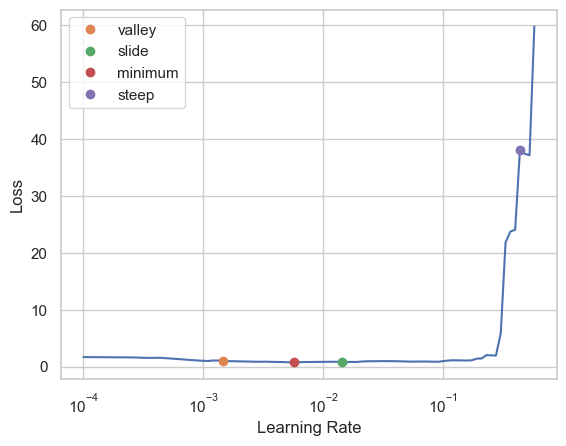

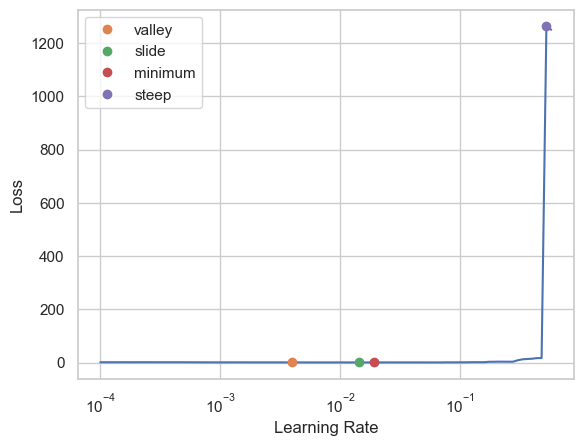

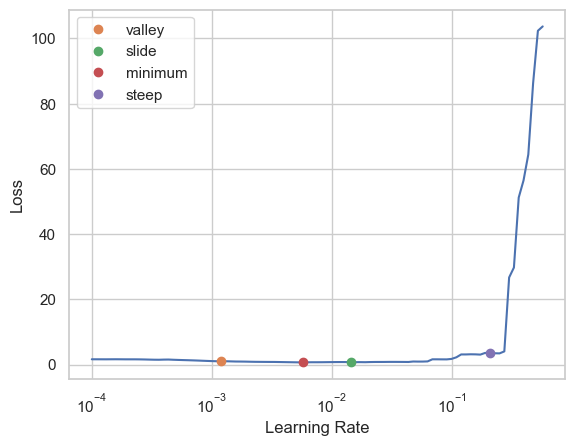

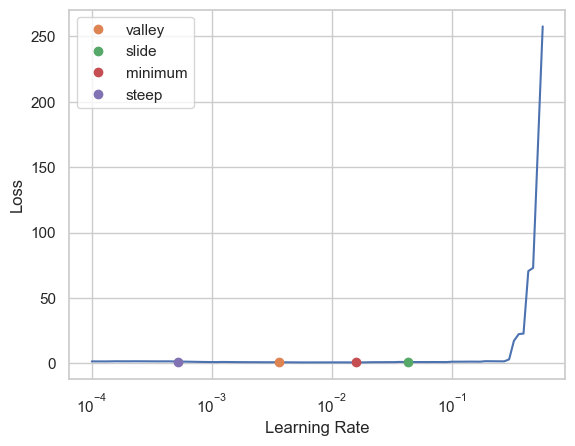

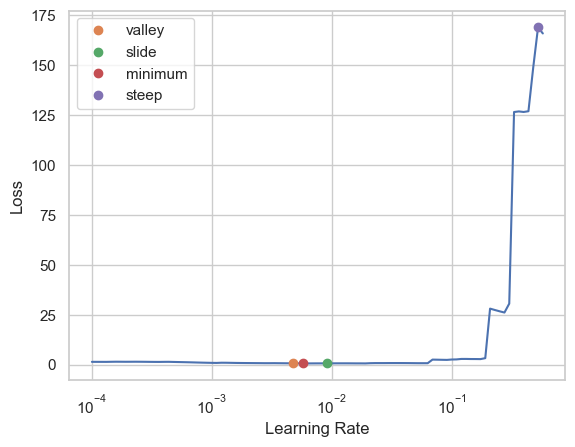

In [88]:
learners = []
suggestions = []
for wd in [1e-5, 3e-5, 1e-4, 3e-4, 0]:
    learn = Learner(
        dls=dls,
        model=TCN(360, 5, [32]*3, 32, 0.125, use_skip_connections=True).cuda(),
        loss_func=nn.CrossEntropyLoss(),
        metrics=[accuracy, Precision(average="macro"), Recall(average="macro"), F1Score(average="macro"), RocAuc(average="macro")],
        path="./models/tcn",
        wd=wd
    )
    suggestion = learn.lr_find(1e-4, 1.0, stop_div=False, suggest_funcs=[valley, slide, minimum, steep])
    suggestions.append(suggestion)
    # learn.recorder.plot_lr_find()
    learners.append(learn)

In [89]:
for suggestion in suggestions:
    print(suggestion)

SuggestedLRs(valley=0.0014454397605732083, slide=0.01445439737290144, minimum=0.0005754399579018354, steep=0.43651583790779114)
SuggestedLRs(valley=0.003981071524322033, slide=0.01445439737290144, minimum=0.0019054606556892395, steep=0.5248074531555176)
SuggestedLRs(valley=0.0012022644514217973, slide=0.01445439737290144, minimum=0.0005754399579018354, steep=0.2089296132326126)
SuggestedLRs(valley=0.00363078061491251, slide=0.04365158453583717, minimum=0.0015848932787775993, steep=0.0005248074885457754)
SuggestedLRs(valley=0.00478630093857646, slide=0.009120108559727669, minimum=0.0005754399579018354, steep=0.5248074531555176)


# Training

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, precision_recall_curve
from fastai.callback.core import Callback
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.progress import ProgressCallback, ShowGraphCallback, CSVLogger
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.schedule import fit_one_cycle
from fastai.metrics import skm_to_fastai

In [18]:
import json

In [25]:
if os.path.exists('models/prototyping/model.json'):
    with open('models/prototyping/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open('models/prototyping/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)

In [20]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_ys = np.array([y for _, y in train_set.data])

In [21]:
class LogInterruptable(Callback):
    def after_epoch(self):
        interruptable_info["epoch"] = self.epoch
        with open('models/prototyping/model.json', 'w') as f:
            json.dump(interruptable_info, f, indent=4)

In [22]:
def fastai_precision_score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'):
    return skm_to_fastai(precision_score, axis=axis, labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, zero_division=zero_division)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.593776,1.586247,0.057443,0.011489,0.200000,0.021729,0.437048,00:24
1,1.559006,1.538198,0.082767,0.016555,0.200000,0.030579,0.529316,00:25
2,1.515475,1.480194,0.082767,0.016553,0.200000,0.030576,0.515169,00:25
3,1.458531,1.405332,0.082767,0.016553,0.200000,0.030576,0.521294,00:25
4,1.382083,1.301335,0.082767,0.016553,0.200000,0.030576,0.640836,00:24
5,1.261126,1.087623,0.082767,0.016553,0.200000,0.030576,0.625069,00:24
6,1.040825,1.001863,0.082767,0.016560,0.200000,0.030588,0.625729,00:24
7,0.857415,0.843659,0.082767,0.016567,0.200000,0.030599,0.589784,00:25
8,0.728596,0.816604,0.082767,0.016574,0.200000,0.030611,0.590631,00:24
9,0.635553,0.763076,0.082973,0.041596,0.200717,0.032043,0.596655,00:24


Better model found at epoch 0 with valid_loss value: 1.5862473249435425.


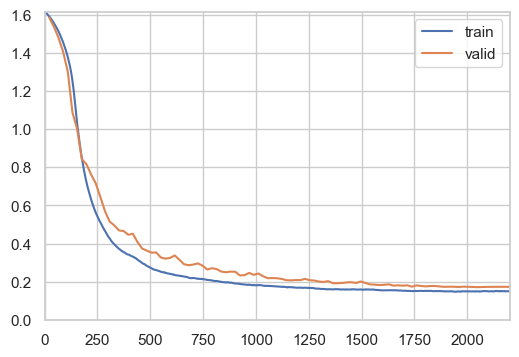

Better model found at epoch 1 with valid_loss value: 1.5381981134414673.
Better model found at epoch 2 with valid_loss value: 1.480193853378296.
Better model found at epoch 3 with valid_loss value: 1.4053318500518799.
Better model found at epoch 4 with valid_loss value: 1.3013349771499634.
Better model found at epoch 5 with valid_loss value: 1.0876234769821167.
Better model found at epoch 6 with valid_loss value: 1.0018630027770996.
Better model found at epoch 7 with valid_loss value: 0.8436591029167175.
Better model found at epoch 8 with valid_loss value: 0.816604495048523.
Better model found at epoch 9 with valid_loss value: 0.7630762457847595.
Better model found at epoch 10 with valid_loss value: 0.7160434126853943.
Better model found at epoch 11 with valid_loss value: 0.6440597772598267.
Better model found at epoch 12 with valid_loss value: 0.5696802735328674.
Better model found at epoch 13 with valid_loss value: 0.5154771208763123.
Better model found at epoch 14 with valid_loss va

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,2.280231,2.128247,0.829216,0.165843,0.200000,0.181327,0.405020,00:25
1,2.267294,2.109527,0.829216,0.165843,0.200000,0.181327,0.467580,00:25
2,2.248443,2.074903,0.829216,0.165843,0.200000,0.181327,0.498046,00:25
3,2.214427,2.008985,0.829216,0.165843,0.200000,0.181327,0.538352,00:24
4,2.138490,1.811232,0.829216,0.165843,0.200000,0.181327,0.547104,00:25
5,1.804210,1.370620,0.082767,0.016553,0.200000,0.030576,0.466339,00:24
6,1.413976,0.941060,0.082767,0.016553,0.200000,0.030576,0.462464,00:25
7,1.126089,0.943965,0.082767,0.016553,0.200000,0.030576,0.472957,00:24
8,0.937445,0.939030,0.082767,0.016553,0.200000,0.030576,0.487537,00:25
9,0.813925,0.959269,0.082767,0.016553,0.200000,0.030576,0.495608,00:24


Better model found at epoch 0 with valid_loss value: 2.1282474994659424.


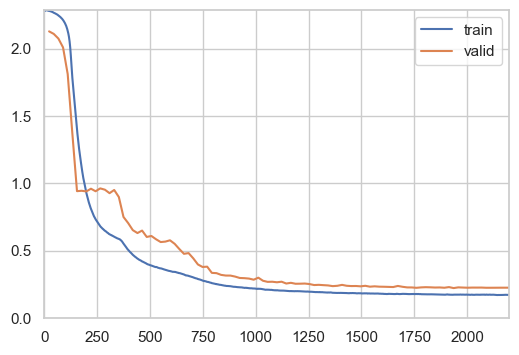

Better model found at epoch 1 with valid_loss value: 2.109527111053467.
Better model found at epoch 2 with valid_loss value: 2.0749027729034424.
Better model found at epoch 3 with valid_loss value: 2.0089850425720215.
Better model found at epoch 4 with valid_loss value: 1.811232328414917.
Better model found at epoch 5 with valid_loss value: 1.3706196546554565.
Better model found at epoch 6 with valid_loss value: 0.9410601258277893.
Better model found at epoch 8 with valid_loss value: 0.9390295147895813.
Better model found at epoch 13 with valid_loss value: 0.9260560870170593.
Better model found at epoch 15 with valid_loss value: 0.8973909616470337.
Better model found at epoch 16 with valid_loss value: 0.7491477727890015.
Better model found at epoch 17 with valid_loss value: 0.7041212916374207.
Better model found at epoch 18 with valid_loss value: 0.6514153480529785.
Better model found at epoch 19 with valid_loss value: 0.6297409534454346.
Better model found at epoch 21 with valid_loss 

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.205941,1.286430,0.082767,0.016553,0.200000,0.030576,0.416713,00:25
1,1.176684,1.249266,0.082767,0.016553,0.200000,0.030576,0.562740,00:25
2,1.138243,1.201043,0.082767,0.016553,0.200000,0.030576,0.575418,00:25
3,1.085604,1.139051,0.082767,0.016553,0.200000,0.030576,0.596337,00:25
4,1.009696,1.048968,0.082767,0.016553,0.200000,0.030576,0.606231,00:24
5,0.895872,1.003105,0.082767,0.016553,0.200000,0.030576,0.583072,00:25
6,0.788332,1.089027,0.082767,0.016553,0.200000,0.030576,0.576433,00:24
7,0.711583,0.975687,0.082767,0.016553,0.200000,0.030576,0.585301,00:25
8,0.658800,0.974417,0.082767,0.016553,0.200000,0.030576,0.589270,00:24
9,0.617618,0.928798,0.082767,0.016553,0.200000,0.030576,0.605477,00:25


Better model found at epoch 0 with valid_loss value: 1.286429762840271.


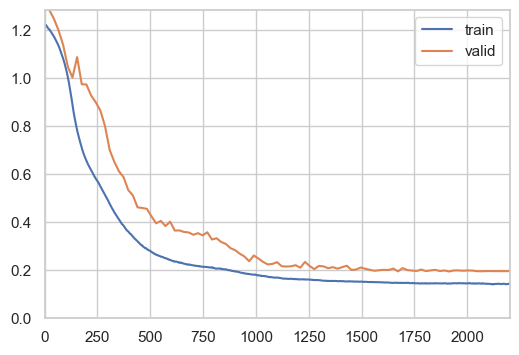

Better model found at epoch 1 with valid_loss value: 1.2492655515670776.
Better model found at epoch 2 with valid_loss value: 1.2010430097579956.
Better model found at epoch 3 with valid_loss value: 1.1390513181686401.
Better model found at epoch 4 with valid_loss value: 1.0489678382873535.
Better model found at epoch 5 with valid_loss value: 1.003104567527771.
Better model found at epoch 7 with valid_loss value: 0.9756872653961182.
Better model found at epoch 8 with valid_loss value: 0.974416971206665.
Better model found at epoch 9 with valid_loss value: 0.9287976026535034.
Better model found at epoch 10 with valid_loss value: 0.9005703926086426.
Better model found at epoch 11 with valid_loss value: 0.8655713796615601.
Better model found at epoch 12 with valid_loss value: 0.8004077672958374.
Better model found at epoch 13 with valid_loss value: 0.7012335658073425.
Better model found at epoch 14 with valid_loss value: 0.6515628695487976.
Better model found at epoch 15 with valid_loss v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.470842,1.501083,0.084826,0.027968,0.299751,0.051117,0.597711,00:25
1,1.459059,1.482389,0.082870,0.018690,0.204762,0.033653,0.574061,00:25
2,1.440190,1.449316,0.082767,0.016576,0.200000,0.030614,0.488474,00:25
3,1.405237,1.382653,0.082767,0.016553,0.200000,0.030576,0.494465,00:24
4,1.299121,1.008512,0.082767,0.016553,0.200000,0.030576,0.594424,00:25
5,1.057706,0.926863,0.082767,0.016553,0.200000,0.030576,0.609659,00:25
6,0.885728,0.980993,0.082767,0.016553,0.200000,0.030576,0.617511,00:24
7,0.764896,0.910229,0.082767,0.016553,0.200000,0.030576,0.591858,00:24
8,0.684759,0.880973,0.082767,0.016553,0.200000,0.030576,0.571668,00:25
9,0.628826,0.839787,0.082767,0.016553,0.200000,0.030576,0.570889,00:25


Better model found at epoch 0 with valid_loss value: 1.5010827779769897.


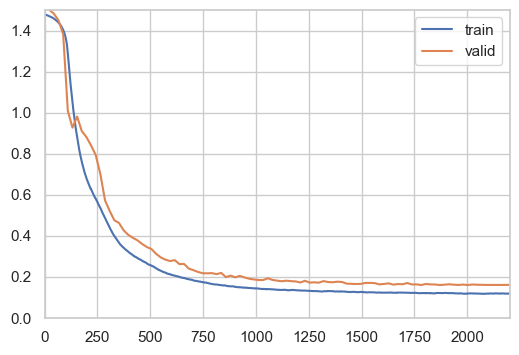

Better model found at epoch 1 with valid_loss value: 1.4823894500732422.
Better model found at epoch 2 with valid_loss value: 1.449316382408142.
Better model found at epoch 3 with valid_loss value: 1.3826534748077393.
Better model found at epoch 4 with valid_loss value: 1.0085119009017944.
Better model found at epoch 5 with valid_loss value: 0.9268627762794495.
Better model found at epoch 7 with valid_loss value: 0.9102285504341125.
Better model found at epoch 8 with valid_loss value: 0.8809728026390076.
Better model found at epoch 9 with valid_loss value: 0.8397866487503052.
Better model found at epoch 10 with valid_loss value: 0.7935190796852112.
Better model found at epoch 11 with valid_loss value: 0.7002895474433899.
Better model found at epoch 12 with valid_loss value: 0.5727553367614746.
Better model found at epoch 13 with valid_loss value: 0.5208471417427063.
Better model found at epoch 14 with valid_loss value: 0.47546684741973877.
Better model found at epoch 15 with valid_loss

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,2.290513,2.114567,0.026251,0.005250,0.200000,0.010232,0.432187,00:25
1,2.253968,2.058233,0.026251,0.005250,0.200000,0.010232,0.438610,00:25
2,2.203889,1.983549,0.026251,0.005250,0.200000,0.010232,0.443493,00:25
3,2.129468,1.851357,0.026251,0.005250,0.200000,0.010232,0.528147,00:24
4,1.927927,1.132574,0.082767,0.016553,0.200000,0.030576,0.674615,00:25
5,1.485238,1.025533,0.082767,0.016553,0.200000,0.030576,0.671883,00:24
6,1.166164,0.908840,0.082767,0.016553,0.200000,0.030576,0.680966,00:25
7,0.952559,0.862991,0.082767,0.016553,0.200000,0.030576,0.627416,00:25
8,0.808447,0.868601,0.082767,0.016553,0.200000,0.030576,0.597266,00:24
9,0.704727,0.801305,0.082767,0.016553,0.200000,0.030576,0.580135,00:25


Better model found at epoch 0 with valid_loss value: 2.1145670413970947.


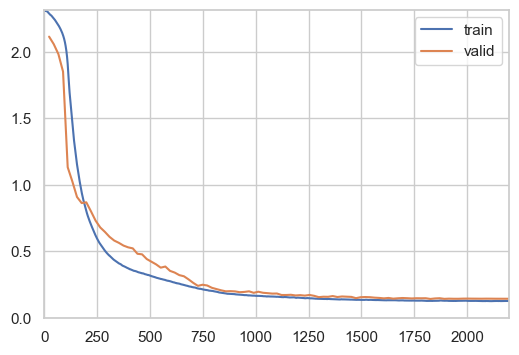

Better model found at epoch 1 with valid_loss value: 2.0582327842712402.
Better model found at epoch 2 with valid_loss value: 1.9835492372512817.
Better model found at epoch 3 with valid_loss value: 1.8513572216033936.
Better model found at epoch 4 with valid_loss value: 1.1325740814208984.
Better model found at epoch 5 with valid_loss value: 1.0255329608917236.
Better model found at epoch 6 with valid_loss value: 0.9088404178619385.
Better model found at epoch 7 with valid_loss value: 0.862991213798523.
Better model found at epoch 9 with valid_loss value: 0.8013046383857727.
Better model found at epoch 10 with valid_loss value: 0.7306843400001526.
Better model found at epoch 11 with valid_loss value: 0.6795281171798706.
Better model found at epoch 12 with valid_loss value: 0.6462292075157166.
Better model found at epoch 13 with valid_loss value: 0.6087934970855713.
Better model found at epoch 14 with valid_loss value: 0.5810191035270691.
Better model found at epoch 15 with valid_loss 

In [26]:
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    tcn_model = TCN(360, 5, [2]*9, 32, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=4096, shuffle=True, pin_memory=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=4096, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    csv_logger = CSVLogger(fname=f"./models/prototyping/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"./models/prototyping/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(weight=class_weights.cuda()),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro"), RocAuc(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"./models/prototyping/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"./models/prototyping/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-3,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=3e-4,
        cbs=[best_model_cb, every_epoch_save_cb, csv_logger, LogInterruptable(), ShowGraphCallback()],
    )
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open('models/prototyping/model.json', 'w'), indent=4)